# import dependecies

In [1]:
import numpy as np
import pandas as pd
import re
import ast

# reading movies datasets

In [2]:
#ava_movies_df = pd.read_csv('/content/drive/MyDrive/nlp_datasets/ava_movies.csv')
digi_movies_df = pd.read_csv('/content/drive/MyDrive/nlp/digi_movies.csv')
kio_movies_df = pd.read_csv('/content/drive/MyDrive/nlp/kio_movies.csv')
tiny_movies_df = pd.read_csv('/content/drive/MyDrive/nlp/tiny_movies.csv')
uptv_movies_df = pd.read_csv('/content/drive/MyDrive/nlp/uptv_movies.csv')
validation_dataset = pd.read_csv('/content/drive/MyDrive/nlp/movie_data_set.csv')

# preprocessing

In [3]:
# Function to extract IMDb IDs
def extract_imdb_id(url):
    if pd.isna(url):  # Handle NaN values
        return None
    match = re.search(r'tt(\d+)', str(url))  # Convert to string before applying regex
    if match:
        return f"tt{match.group(1)}"
    else:
        return None

extract imdb's ids

In [4]:
digi_movies_df['idf'] = digi_movies_df['idf'].apply(extract_imdb_id)
kio_movies_df['idf'] = kio_movies_df['idf'].apply(extract_imdb_id)
tiny_movies_df['idf'] = tiny_movies_df['idf'].apply(extract_imdb_id)
uptv_movies_df['idf'] = uptv_movies_df['idf'].apply(extract_imdb_id)

In [5]:
merged_df = pd.concat([digi_movies_df['idf'], kio_movies_df['idf'], tiny_movies_df['idf'], uptv_movies_df['idf']], axis=1)
merged_df.columns = ['idf1', 'idf2', 'idf3', 'idf4']

# Count the number of unique IMDb IDs in each dataset
unique_counts = merged_df.nunique()

# Count the number of common IMDb IDs between pairs of datasets
common_counts = {}
common_counts['df1_df2'] = merged_df[['idf1', 'idf2']].dropna().nunique()['idf1']
common_counts['df1_df3'] = merged_df[['idf1', 'idf3']].dropna().nunique()['idf1']
common_counts['df1_df4'] = merged_df[['idf1', 'idf4']].dropna().nunique()['idf1']
common_counts['df2_df3'] = merged_df[['idf2', 'idf3']].dropna().nunique()['idf2']
common_counts['df2_df4'] = merged_df[['idf2', 'idf4']].dropna().nunique()['idf2']
common_counts['df3_df4'] = merged_df[['idf3', 'idf4']].dropna().nunique()['idf3']

# Count the number of common IMDb IDs across all four datasets
common_counts['all_datasets'] = merged_df.dropna().nunique().min()

# Print the results
print("Number of unique IMDb IDs in each dataset:")
print(unique_counts)
print("\nNumber of common IMDb IDs between pairs of datasets and across all four datasets:")
print(common_counts)

Number of unique IMDb IDs in each dataset:
idf1    6833
idf2    9455
idf3    1698
idf4    4681
dtype: int64

Number of common IMDb IDs between pairs of datasets and across all four datasets:
{'df1_df2': 6831, 'df1_df3': 1693, 'df1_df4': 4724, 'df2_df3': 1696, 'df2_df4': 4724, 'df3_df4': 1695, 'all_datasets': 1673}


drop duplicates based on imdb's ids

In [6]:
# Drop duplicates based on IMDb ID column in each dataframe
digi_movies_df = digi_movies_df.drop_duplicates(subset=['idf'])
tiny_movies_df = tiny_movies_df.drop_duplicates(subset=['idf'])
uptv_movies_df = uptv_movies_df.drop_duplicates(subset=['idf'])
kio_movies_df = kio_movies_df.drop_duplicates(subset=['idf'])

In [7]:
tiny_movies_df = tiny_movies_df.rename(columns={'summ': 'summary'})

merge datasets based on imdb's ids



In [8]:
# Merge digi_movies_df summary into kio_movies_df
kio_movies_df = kio_movies_df.merge(digi_movies_df[['idf', 'summary']], on='idf', how='left', suffixes=('', '_digi'))

# Merge tiny_movies_df summary into kio_movies_df
kio_movies_df = kio_movies_df.merge(tiny_movies_df[['idf', 'summary']], on='idf', how='left', suffixes=('', '_tiny'))

# Merge uptv_movies_df summary into kio_movies_df
kio_movies_df = kio_movies_df.merge(uptv_movies_df[['idf', 'summary', 'story']], on='idf', how='left', suffixes=('', '_uptv'))

In [9]:
kio_movies_df = kio_movies_df.rename(columns={'summary': 'summary_kio'})

In [10]:
kio_movies_df['actors'] = kio_movies_df['actors'].apply(ast.literal_eval)
kio_movies_df['genres'] = kio_movies_df['genres'].apply(ast.literal_eval)
kio_movies_df['countries'] = kio_movies_df['countries'].apply(ast.literal_eval)
kio_movies_df['languages'] = kio_movies_df['languages'].apply(ast.literal_eval)
kio_movies_df['directors'] = kio_movies_df['directors'].apply(ast.literal_eval)
kio_movies_df['authors'] = kio_movies_df['authors'].apply(ast.literal_eval)
kio_movies_df['stars'] = kio_movies_df['stars'].apply(ast.literal_eval)


remove unneccesaries coloumns

In [11]:
kio_movies_df.drop(columns=['crit_score', 'tomato_score'], inplace=True)

In [12]:
kio_movies_df['imdb_score'] = kio_movies_df['imdb_score'].apply(lambda x: x.split('/')[0])


In [13]:
kio_movies_df['release'] = kio_movies_df['release'].astype(str).apply(lambda x: x.split('.')[0])

preprocess text of summaries of movies

In [14]:
def preprocess_persian_text(text):
  if isinstance(text, str):
    # Remove white spaces
    text = re.sub(r'\s{2,}', ' ', text)

    # Change English numbers to Persian numbers
    persian_numbers = {'0': '۰', '1': '۱', '2': '۲', '3': '۳', '4': '۴',
                       '5': '۵', '6': '۶', '7': '۷', '8': '۸', '9': '۹'}
    for eng_num, per_num in persian_numbers.items():
        text = text.replace(eng_num, per_num)

    # Add more preprocessing steps here if needed

    return text

In [15]:
kio_movies_df['summary_kio'] = kio_movies_df['summary_kio'].apply(preprocess_persian_text)
kio_movies_df['summary_digi'] = kio_movies_df['summary_digi'].apply(preprocess_persian_text)
kio_movies_df['summary_tiny'] = kio_movies_df['summary_tiny'].apply(preprocess_persian_text)
kio_movies_df['summary_uptv'] = kio_movies_df['summary_uptv'].apply(preprocess_persian_text)
kio_movies_df['story'] = kio_movies_df['story'].apply(preprocess_persian_text)

In [16]:
# Flatten the lists in the 'languages' column
flattened_languages = kio_movies_df['languages'].explode()

# Get unique values
unique_languages = flattened_languages.unique()

# Print unique values
print(unique_languages)

['English' 'Hindi' 'Cantonese' 'Italian' 'Spanish' 'Mandarin' 'Russian'
 'Japanese' 'Japanese Sign Language' 'Portuguese' 'Thai' 'Ukrainian'
 'German' 'Chinese' 'French' 'Bulgarian' 'Esperanto' 'Abkhazian' 'Urdu'
 'Korean' 'None' 'Latin' 'Old English' 'Malay' 'Vietnamese' 'Inuktitut'
 'Croatian' 'Serbian' 'Yiddish' nan 'Indonesian' 'Norwegian' 'Greek'
 'Catalan' 'Saami' 'Hawaiian' 'American Sign Language' 'Tibetan'
 'Armenian' 'Min Nan' 'Icelandic' 'Algonquin' 'Arabic' 'Danish'
 'Irish Gaelic' 'Gaelic' 'Turkish' 'Swahili' 'Xhosa' 'Zulu' 'Dutch'
 'Hebrew' 'Hungarian' 'Polish' 'Shanghainese' 'Czech' 'Bengali' 'Persian'
 'Punjabi' 'Somali' 'Swedish' 'Navajo' 'Bosnian' 'Corsican' 'Tswana'
 'Filipino' 'Tamil' 'Telugu' 'Malayalam' 'Kannada' 'Romanian' 'Romany'
 'Middle English' 'Marathi' 'Quechua' 'Lao' 'Azerbaijani' 'Mende'
 'Georgian' 'Tatar' 'Swiss German' ' Ancient (to 1453)' 'Maya'
 'Apache languages' 'Maori' 'Bable' 'Lithuanian' 'Korean Sign Language'
 'Wolof' 'Finnish' 'Aboriginal' 'K

In [17]:
language_mapping = {
    'English': 'انگلیسی',
    'Hindi': 'هندی',
    'Cantonese': 'کانتونی',
    'Italian': 'ایتالیایی',
    'Spanish': 'اسپانیایی',
    'Mandarin': 'ماندارین',
    'Russian': 'روسی',
    'Japanese': 'ژاپنی',
    'Japanese Sign Language': 'زبان اشاره ژاپنی',
    'Portuguese': 'پرتغالی',
    'Thai': 'تایلندی',
    'Ukrainian': 'اوکراینی',
    'German': 'آلمانی',
    'Chinese': 'چینی',
    'French': 'فرانسوی',
    'Bulgarian': 'بلغاری',
    'Esperanto': 'اسپرانتو',
    'Abkhazian': 'آبخازی',
    'Urdu': 'اردو',
    'Korean': 'کره ای',
    'None': 'هیچ',
    'Latin': 'لاتین',
    'Old English': 'انگلیسی باستان',
    'Malay': 'مالایی',
    'Vietnamese': 'ویتنامی',
    'Inuktitut': 'اینوکتیتوت',
    'Croatian': 'کرواتی',
    'Serbian': 'صربی',
    'Yiddish': 'یدیش',
    'Indonesian': 'اندونزیایی',
    'Norwegian': 'نروژی',
    'Greek': 'یونانی',
    'Catalan': 'کاتالان',
    'Saami': 'سامی',
    'Hawaiian': 'هاوایی',
    'American Sign Language': 'زبان اشاره آمریکایی',
    'Tibetan': 'تبتی',
    'Armenian': 'ارمنی',
    'Min Nan': 'مین نان',
    'Icelandic': 'ایسلندی',
    'Algonquin': 'الگونکین',
    'Arabic': 'عربی',
    'Danish': 'دانمارکی',
    'Irish Gaelic': 'ایرلندی',
    'Gaelic': 'گیلیک',
    'Turkish': 'ترکی',
    'Swahili': 'سواهیلی',
    'Xhosa': 'خوسا',
    'Zulu': 'زولو',
    'Dutch': 'هلندی',
    'Hebrew': 'عبری',
    'Hungarian': 'مجاری',
    'Polish': 'لهستانی',
    'Shanghainese': 'شانگهایی',
    'Czech': 'چکی',
    'Bengali': 'بنگالی',
    'Persian': 'فارسی',
    'Punjabi': 'پنجابی',
    'Somali': 'سومالیایی',
    'Swedish': 'سوئدی',
    'Navajo': 'ناواهو',
    'Bosnian': 'بوسنیایی',
    'Corsican': 'کرسی',
    'Tswana': 'تسوانا',
    'Filipino': 'فیلیپینی',
    'Tamil': 'تامیل',
    'Telugu': 'تلوگو',
    'Malayalam': 'مالایالم',
    'Kannada': 'کانادا',
    'Romanian': 'رومانیایی',
    'Romany': 'رومانی',
    'Middle English': 'انگلیسی میانه',
    'Marathi': 'مراتی',
    'Quechua': 'کویچوایی',
    'Lao': 'لاوی',
    'Azerbaijani': 'آذربایجانی',
    'Mende': 'منده',
    'Georgian': 'گرجی',
    'Tatar': 'تاتاری',
    'Swiss German': 'آلمانی سوئیسی',
    ' Ancient (to 1453)': 'باستانی (تا ۱۴۵۳)',
    'Maya': 'مایا',
    'Apache languages': 'زبان‌های آپاچی',
    'Maori': 'مائوری',
    'Bable': 'بابل',
    'Lithuanian': 'لیتوانیایی',
    'Korean Sign Language': 'زبان اشاره کره ای',
    'Wolof': 'ولوف',
    'Finnish': 'فنلاندی',
    'Aboriginal': 'بومی',
    'Kyrgyz': 'قرقیزی',
    'Berber languages': 'زبان‌های بربری',
    'Awadhi': 'آوادی',
    'Akan': 'اکان',
    'Macedonian': 'مقدونی',
    'Albanian': 'آلبانیایی',
    'Serbo-Croatian': 'صرب و کروات',
    'Kurdish': 'کردی',
    'Soninke': 'سونینکه',
    'Amharic': 'امهری',
    'Central Khmer': 'خمری مرکزی',
    'Chechen': 'چچنی',
    'Chaozhou': 'چائوژو',
    'Dari': 'دری',
    'Wayuu': 'وایو',
    'Nama': 'ناما',
    'Latvian': 'لتونیایی',
    'Afrikaans': 'آفریکانس',
    'British Sign Language': 'زبان اشاره بریتانیایی',
    'Crow': 'کرو',
    'Mongolian': 'مغولی',
    'Basque': 'باسکی',
    'Slovak': 'اسلواکی',
    'Teochew': 'تئوچئویی',
    'Flemish': 'فلاندری',
    'Ewe': 'اوه',
    'Spanish Sign Language': 'زبان اشاره اسپانیایی',
    'Malinka': 'مالینکا',
    'French Sign Language': 'زبان اشاره فرانسوی',
    'Shoshoni': 'شوشونی',
    'Belarusian': 'بلاروسی',
    'Slovenian': 'اسلوونیایی',
    'Tagalog': 'تاگالوگ',
    'Hokkien': 'هوکیانی',
    'Sign Languages': 'زبان‌های اشاره',
    'Sioux': 'سیو',
    'Pawnee': 'پاونی',
    'Cree': 'کری',
    'Polynesian': 'پلی‌نزی',
    'Nyanja': 'نیانجا',
    'Sotho': 'سوتو',
    'Sumerian': 'سومری',
    'Welsh': 'ویلزی',
    'Syriac': 'سریانی',
    'Assyrian Neo-Aramaic': 'آشوری',
    'Samoan': 'ساموآیی',
    'Scots': 'اسکاتلندی',
    'North American Indian': 'هندی آمریکای شمالی',
    'Klingon': 'کلینگون',
    'Hmong': 'همونگ',
    'Greenlandic': 'گرینلندی',
    'Yoruba': 'یوروبا',
    'Dinka': 'دینکا',
    'Cheyenne': 'شاینی',
    'Kinyarwanda': 'کینیارواندا',
    'Bemba': 'بمبا',
    'Tonga (Tonga Islands)': 'تونگایی (جزایر تونگا)',
    'Nepali': 'نپالی',
    'Sinhala': 'سینهالا',
    'Brazilian Sign Language': 'زبان اشاره برزیلی',
    'Kashmiri': 'کشمیری',
    'Tupi': 'توپی',
    'Sicilian': 'سیسیلی',
    'Cornish': 'کورنی',
    'Bambara': 'بامبارا',
    'Pashtu': 'پشتو',
    'Uzbek': 'ازبکی',
    'Acholi': 'آچولی',
    'Neapolitan': 'ناپلی',
    'Gujarati': 'گجراتی',
    'Maltese': 'مالتی',
    'Mohawk': 'موهاک',
    'Mapudungun': 'ماپودونگان',
    'Dyula': 'دیولا',
    'Nushi': 'نوشی',
    'Estonian': 'استونیایی',
    'Rajasthani': 'راجستانی',
    'Burmese': 'برمه‌ای',
    'Norse': 'نورس',
    ' Old': 'قدیمی',
    'Kriolu': 'کریولو',
    'Aragonese': 'آراگونی',
    'Papiamento': 'پاپیامنتو',
    'Kirundi': 'کیروندی',
    'Washoe': 'واشو',
    'Hausa': 'هوسا',
    'Mixtec': 'میکستک',
    'Luxembourgish': 'لوکزامبورگی',
    'Sanskrit': 'سانسکریت',
    'Egyptian (Ancient)': 'مصری باستانی',
    'Aramaic': 'آرامی',
    'Haryanvi': 'هاریانوی',
    'Galician': 'گالیسیایی',
    'Germany': 'آلمان',
    'Haitian': 'هائیتیایی',
    'Ungwatsi': 'اونگواتسی',
    'Lingala': 'لینگالا',
    'Guarani': 'گوارانی',
    'Assamese': 'آسامی',
    'Oriya': 'اوریا',
    'Sindarin': 'سیندارین',
    'Quenya': 'کوئنیا',
    'Tok Pisin': 'توک پیسین',
    'Ukrainian Sign Language': 'زبان اشاره اوکراینی',
    'Songhay': 'سونگای',
    'Tamashek': 'تاماشک',
    'Ibo': 'ایبو',
    'Bhojpuri': 'بهوجپوری',
    'Turkmen': 'ترکمنی',
    'East-Greenlandic': 'گرینلند شرقی',
    'Kazakh': 'قزاقی'
}


In [18]:
kio_movies_df['languages_fa'] = kio_movies_df['languages'].apply(lambda x: [language_mapping[l] for l in x])

In [19]:
# Flatten the lists in the 'languages' column
flattened_countries = kio_movies_df['countries'].explode()

# Get unique values
unique_countries = flattened_countries.unique()

# Print unique values
print(unique_countries)

['آمریکا' 'کانادا' 'هنگ کنگ' 'آلمان' 'انگلستان' 'ژاپن' 'چين' 'کره جنوبی'
 'فرانسه' 'استرالیا' 'تایوان' 'بلژیک' 'مکزیک' 'اسپانیا' 'ایرلند' 'لتونی'
 'هندوستان' 'مالزی' nan 'لوکزامبورگ' 'کلمبیا' 'اتریش' 'دانمارک' 'نروژ'
 'سوئیس' 'لهستان' 'هلند' 'اوکراین' 'نیوزلند' 'پرو' 'اندونزی'
 'امارات متحده عربی' 'برزیل' 'جمهوری چک' 'فنلاند' 'اسرائيل' 'ایتالیا'
 'مجارستان' 'سوئد' 'شیلی' 'آلمان غربی' 'لیتوانی' 'کامبوج' 'ایران'
 'آرژانتین' 'اروگوئه' 'ایسلند' 'ترکیه' 'روسیه' 'بلغارستان' 'رومانی' 'مالت'
 'آذربایجان' 'گرجستان' 'اتحاد جماهیر شوروی' 'اسلوونی' 'یونان' 'سنگاپور'
 'قطر' 'مراکش' 'مصر' 'سنگال' 'قزاقستان' 'تایلند' 'تونس' 'لبنان'
 'جمهوری مقدونیه' 'پرتغال' 'جمهوری فدرال یوگسلاوی' 'بولیوی' 'کره' 'قبرس'
 'باهاما' 'اسلواکی' 'غنا' 'استونی' 'بلاروس' 'چکسلواکی' 'صربستان' 'الجزایر'
 'کرواسی' 'آفریقای جنوبی' 'پورتوریکو' 'ونزوئلا' 'پاناما' 'اردن'
 'عربستان سعودی' 'فیلیپین' 'عراق' 'بوسنی و هرزگوین' 'North Macedonia'
 'آلبانی' 'کوزوو' 'Serbia and Montenegro' 'زامبیا' 'ویتنام' 'نیجریه'
 'سرزمین فلسطین اشغالی' 

In [20]:
country_mapping = {
    'North Macedonia': 'مقدونیه شمالی',
    'Serbia and Montenegro': 'صربستان و مونته\u200cنگرو',
    "Côte d'Ivoire": 'ساحل عاج',
    'Netherlands Antilles': 'آنتیل هلند',
    'North Korea': 'کره شمالی',
    'Saint Kitts and Nevis': 'سنت کیتس و نویس',
}

In [21]:
def map_to_persian(countries):
    persian_countries = [country_mapping[country] if country in country_mapping else country for country in countries]
    return persian_countries

# Apply the mapping function directly to the 'countries' column
kio_movies_df['countries'] = kio_movies_df['countries'].apply(map_to_persian)


drop rows that not have name or imdb's id

In [22]:
 kio_movies_df.dropna(subset=['name','idf'],inplace=True)

In [23]:
all_none_rows = kio_movies_df[['summary_kio','summary_digi','summary_tiny','summary_uptv' ,'story']].isnull().all(axis=1)
kio_movies_df = kio_movies_df[~all_none_rows]

create a column that contain all of summaries

In [24]:
kio_movies_df['total_summary'] = kio_movies_df.apply(lambda row: '\n'.join([str(item) for item in [row['summary_digi'], row['summary_kio'], row['summary_tiny'], row['summary_uptv'], row['story']] if item is not None]), axis=1)

In [25]:
kio_movies_df.reset_index(drop=True, inplace=True)

merge dataset for validation part

In [26]:
final_df = pd.merge(kio_movies_df, validation_dataset[['idf', 'similar_movies']], on='idf', how='left')

In [27]:
def convert_to_list_of_tuples(string_repr):
    if pd.isna(string_repr):
        return []
    else:
        return ast.literal_eval(string_repr)

In [28]:
final_df['similar_movies'] = final_df['similar_movies'].apply(convert_to_list_of_tuples)

In [29]:
data_set = final_df.copy(True)

for index, row in data_set.iterrows():
  for tup in row["similar_movies"]:
    if tup[1] not in data_set["idf"].tolist():
      row["similar_movies"].remove(tup)



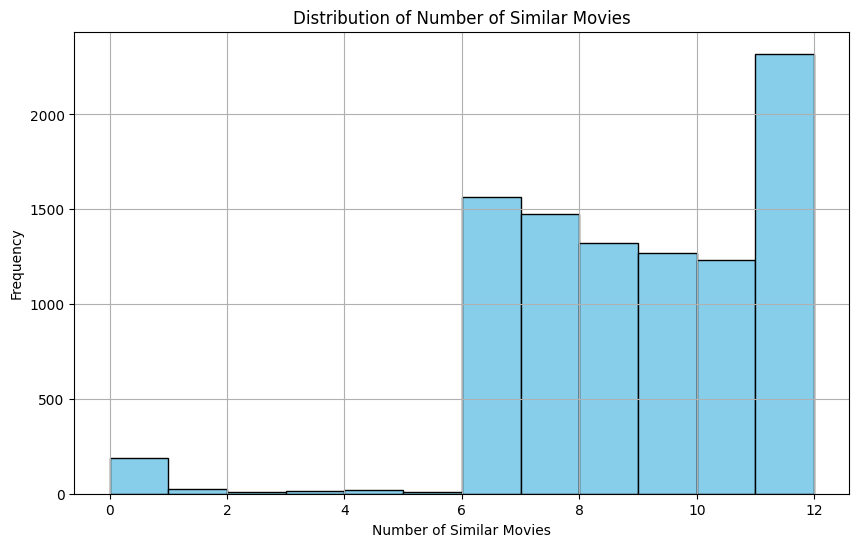

In [30]:
import matplotlib.pyplot as plt

# Drop NaN values and calculate the number of movies in each list
similar_movies_counts = data_set['similar_movies'].dropna().apply(len)

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(similar_movies_counts, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Number of Similar Movies')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Similar Movies')
plt.grid(True)
plt.show()

In [31]:
filtered_data = data_set[similar_movies_counts == 12]

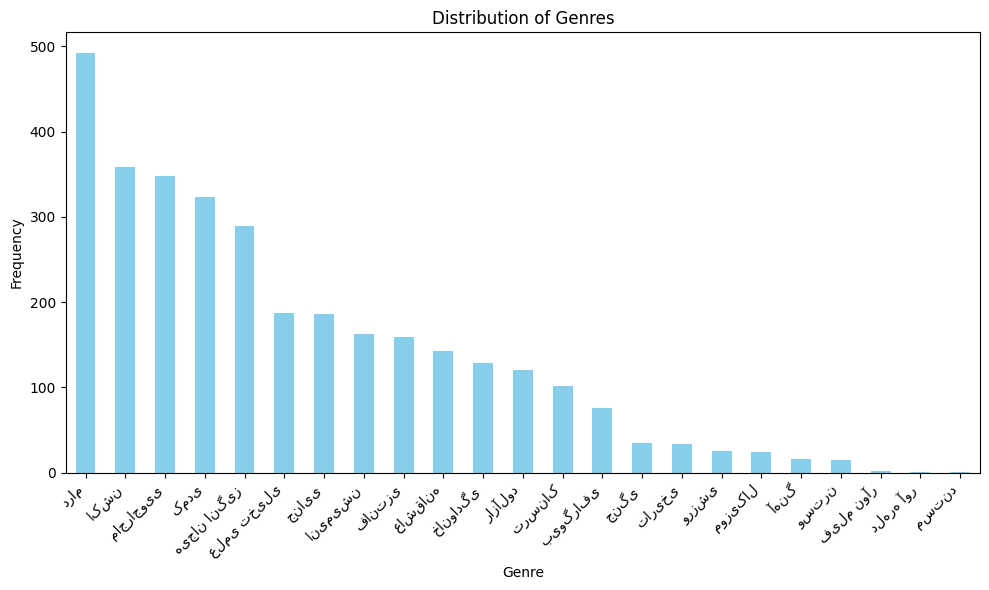

In [32]:
genres = filtered_data['genres'].explode()

# Count occurrences of each genre
genre_counts = genres.value_counts()

# Plot histogram
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [33]:
data_set.to_csv('final_dataset.csv', index=False)

In [34]:
filtered_data.to_csv('validation_dataset.csv', index=False)